In [1]:
import matplotlib.pyplot as plt

from knetworks import knetworks, Network
import numpy as np
from testdata.generator import generateFromGenFile
import torch
import os
%matplotlib inline

%config InlineBackend.figure_format='retina'
if torch.cuda.is_available():
	train_on = "cuda"
else:
	train_on = "cpu"
device = torch.device(train_on)

In [5]:
filename = os.getcwd() + "/../" + "allproducts.txt" #may not work for windows
with open(filename, "r") as file:
    f = file.read()
    products = f.split("\n")

products = [p.upper() for p in products]

features = []
vectors = []
data = [[] for i in range(19)] # warning #cleancode
for f in range(1, 20):
    file = open("testdata/gu_" + str(f) + ".txt", "r") 
    lines = file.readlines()
    features = sorted(str(lines[0]).replace(" ", "").upper().strip().split(","))
    vect = []
    for l in range(len(lines)-1):
        data[f-1].append([])
        vec = lines[l+1].upper().split(",")
        for i in range(len(vec)):
            if int(float(vec[i])) == 1:
                data[f-1][l].append(features[i])
    vectors.append(np.array(vect))
    
vectors = np.array([np.array([np.zeros(len(products), dtype=np.int) for gr_list in range(len(data[user]))]) for user in range(len(data))])
for i,x in enumerate(data):
    for j,y in enumerate(x):
        for k,f in enumerate(products):
            if f in y:
                vectors[i][j][k] = 1

In [30]:
knet = knetworks(6, vectors, len(products), device)
knet.fit()

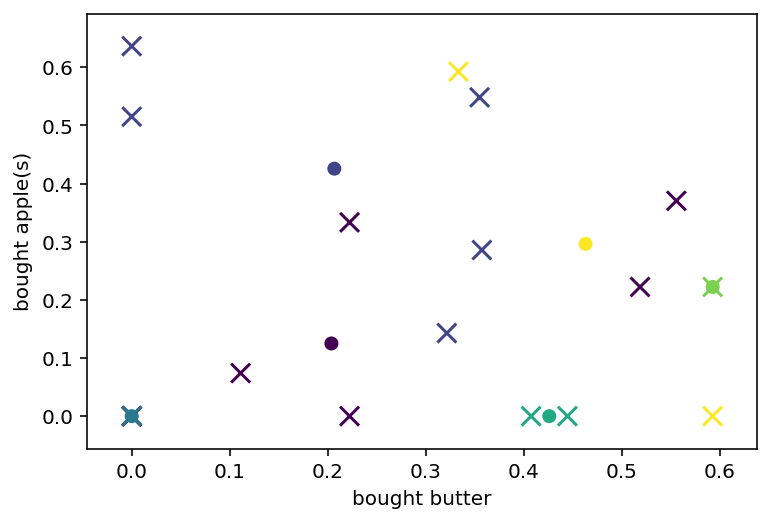

In [34]:
i_butter = products.index("BUTTER")
i_apple = products.index("APFEL")
meanVecs = []
for u in vectors:
    meanVec = np.mean(u, axis=0)
    meanVecs.append(meanVec)
meanVecs = np.array(meanVecs)
meanVecs.shape
plt.scatter(meanVecs[:,i_butter], meanVecs[:,i_apple], marker="x", s=90, c=knet.km.affiliations)
plt.xlabel("bought butter")
plt.ylabel("bought apple(s)")
plt.scatter(knet.km.centroids[:,i_butter], knet.km.centroids[:,i_apple], c=[0,1,2,3,4,5])#why is the purple dot not in the middle of the purple crosses?

In [ ]:
def eval(knet):
    r_gs = []
    f_ps = []
    f_ns = []
    t_ps = []
    n = len(products)
    for user in range(19):
        prediction = np.array(np.squeeze(knet.predict(vectors[user][:-4,:], future=1))) # the prediction for user
        wrong_guesses = np.sum(np.absolute((np.absolute(np.round(prediction)) - vectors[user][-4,:]))) # the right guessed features for one receipt into the future
        false_postives = np.sum(np.maximum((np.absolute(np.round(prediction)) - vectors[user][-4,:]), 0))
        false_negatives = np.sum(np.maximum((vectors[user][-4,:] - np.absolute(np.round(prediction))), 0))
        true_positives = np.sum((np.round(prediction) + vectors[user][-4,:])//2)
        right_guesses = n - wrong_guesses
        true_negatives = right_guesses - true_positives
        r_gs.append(right_guesses)
        f_ps.append(false_postives)
        f_ns.append(false_negatives)
        t_ps.append(true_positives)
        #print(false_postives, false_negatives)
        #print("["+ str(user) + "] Accuracy: " + str(len(products)-int(wrong_guesses)) + "/" + str(len(products)) + " (" + str((len(products)-int(wrong_guesses))/len(products)) + ")")
    m_r_gs = np.mean(r_gs)
    m_f_ps = np.mean(f_ps)
    m_f_ns = np.mean(f_ns)
    m_t_ps = np.mean(t_ps)
    acc = m_r_gs / n
    recall = m_t_ps / (m_t_ps + m_f_ns)
    precision = m_t_ps / (m_t_ps + m_f_ps)
    print("TP,FP,FN: ", m_t_ps, m_f_ps, m_f_ns)
    #print("Accuracy: ", acc)
    #print("True positive rate (recall) (correctly predicted of all YES values): ", recall)
    #print("Precision (correctly predicted of all YES predicted): ", precision)
    return acc, recall, precision

In [ ]:
def test_diffrent_ks():
    performances = []
    for i in [1,2,3,4,5,6,8,10,12,15,19]:
        knet = knetworks(i, vectors[:-4], len(products), device)
        knet.fit()
        knet.train(round(500/np.sqrt(i)),1)#not the same amount for every network, to be a little more fair
        #training time is now O(sqrt(k))
        print("k: ", i)
        acc, rec, prec = eval(knet)
        print("\n")
        performances.append([i,acc,rec,prec])
    return np.array(performances)

def plot_performances(performances):
    plt.plot(performances[:,0], performances[:,1])
    plt.plot(performances[:,0], performances[:,2])
    plt.plot(performances[:,0], performances[:,3])
    plt.savefig("performances.png")
    plt.show()

In [4]:
#performances = test_diffrent_ks() #Luan kannst du das hier mal bitte ausführen
#plot_performances(performances) #und das hier
print(performances)#wäre gut, wenn du den Output rauskopieren und mir schicken könntest

In [ ]:
#after you have finished that, I will take as many centroids as I think it makes sense and test it even more (how well it does with how many training iterations)
##maybe one could use a batch to train the networks, or do we?